# Seasonality analysis

In [2]:
import os
import datetime as dt


import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL

from IPython.display import display, Markdown

import requests_cache
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter



class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD
# symbol = '^GSPC'    # S&P 500




# set maximum number of years to analyze
max_num_of_years = 5



# show seasonality in % instead of currency
seasonalityInPercent = True




def D(text: str):
    display(Markdown(text))






D('## Analysis configuration:')
D(f'* **Symbol selected**: {symbol}')
D(f'* **Max years to analyse**: {dt.date.today().year-1} until earliest {dt.date.today().year-max_num_of_years}')


## Analysis configuration:

* **Symbol selected**: EBAY

* **Max years to analyse**: 2022 until earliest 2018

In [3]:
dirname = '.downloads'
historyFilename = f'{dirname}{os.path.sep}{symbol}_{dt.date.today()}.csv'
cacheFilename = f"{dirname}{os.path.sep}yfinance.cache"

os.makedirs(dirname, exist_ok=True)


session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket),
    backend=SQLiteCache(cacheFilename),
)
ticker = yf.Ticker(symbol, session=session)
df = ticker.history(period='max')

if not os.path.isfile(historyFilename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")[['Close']]
    df.to_csv(historyFilename)
else:
    df = pd.read_csv(historyFilename, parse_dates=['Date'], index_col=['Date'])




D('## Data loaded:')
D(f'* Close prices of symbol _{symbol}_')
D(f'* From {df.index.min().strftime("%d.%m.%y")} to {df.index.max().strftime("%d.%m.%y")}')

#for (k, v) in ticker.info.items():
#    D(f'* {k}: {v}')

D('## Statistics:')
print(df.describe())
D('## Data:')
print(df)

[*********************100%***********************]  1 of 1 completed


## Data loaded:

* Close prices of symbol _EBAY_

* From 24.09.98 to 30.06.23

## Statistics:

             Close
count  6232.000000
mean     22.115576
std      15.992788
min       0.508558
25%      10.003156
50%      16.702440
75%      31.852500
max      80.589996


## Data:

                Close
Date                 
1998-09-24   0.830791
1998-09-25   0.786949
1998-09-28   0.846135
1998-09-29   0.857095
1998-09-30   0.790237
...               ...
2023-06-26  43.459999
2023-06-27  44.470001
2023-06-28  44.840000
2023-06-29  44.599998
2023-06-30  44.689999

[6232 rows x 1 columns]


In [4]:
rolling_resolution = 200

df.index = pd.to_datetime(df.index)
df = df.asfreq('d')                 # set correct frequency
df = df.fillna(method='ffill')      # fill up missing values

annualDf = pd.DataFrame()
numOfYears = 0
for year in sorted(list(set(df.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = df[str(year) + '-01-01':str(year) + '-12-31']['Close'].values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    annualDf[str(year)] = curYearValues

resultMean = annualDf.mean(axis=1)
resultMin = annualDf.min(axis=1)
resultMax = annualDf.max(axis=1)
annualDf['mean'] = resultMean
annualDf['min'] = resultMin
annualDf['max'] = resultMax

lastYear = dt.date.today().year-1
range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='D')
annualDf['date'] = range
annualDf = annualDf.set_index('date')

# annualDf.index = resultDf.index.strftime('%d. %b')

D('## Initial data overview')
annualDf

## Initial data overview

,2022,2021,2020,2019,2018,mean,min,max
date,,,,,,,,
2022-01-01,66.500000,50.250000,36.110001,28.070000,37.740002,43.734000,28.070000,66.500000
2022-01-02,66.500000,50.250000,36.299999,28.850000,38.060001,43.992000,28.850000,66.500000
2022-01-03,66.800003,50.250000,35.959999,28.320000,39.220001,44.110001,28.320000,66.800003
2022-01-04,65.139999,51.500000,35.959999,28.969999,38.570000,44.027999,28.969999,65.139999
2022-01-05,64.489998,52.029999,35.959999,28.969999,39.689999,44.227999,28.969999,64.489998
...,...,...,...,...,...,...,...,...
2022-12-27,40.080002,65.660004,50.119999,36.070000,28.030001,43.992001,28.030001,65.660004
2022-12-28,39.919998,66.080002,50.240002,36.070000,28.240000,44.110000,28.240000,66.080002
2022-12-29,41.820000,66.459999,50.860001,36.070000,28.240000,44.690000,28.240000,66.459999


In [5]:
periods = [4, 12, 52, 365]
periodNames = ['seasonal_' + str(i) for i in periods]

decompose = MSTL(df['Close'], periods=periods)
decompose = decompose.fit()

numOfYears = 0
retDf = pd.DataFrame()
for year in sorted(list(set(decompose.seasonal[periodNames[3]].index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    annualDf[periodNames[3] + '_' + str(year)] = curYearValues

D('## Seasonal decomposition')
annualDf

## Seasonal decomposition

,2022,2021,2020,2019,2018,mean,min,max,seasonal_365_2022,seasonal_365_2021,seasonal_365_2020,seasonal_365_2019,seasonal_365_2018
date,,,,,,,,,,,,,
2022-01-01,66.500000,50.250000,36.110001,28.070000,37.740002,43.734000,28.070000,66.500000,-2.548109,-2.318081,-2.261805,-2.014619,-1.773997
2022-01-02,66.500000,50.250000,36.299999,28.850000,38.060001,43.992000,28.850000,66.500000,-2.580257,-2.343360,-2.091026,-1.868497,-1.651109
2022-01-03,66.800003,50.250000,35.959999,28.320000,39.220001,44.110001,28.320000,66.800003,-2.303745,-2.102679,-2.109505,-1.880348,-1.656518
2022-01-04,65.139999,51.500000,35.959999,28.969999,38.570000,44.027999,28.969999,65.139999,-1.991177,-1.827397,-1.903135,-1.707028,-1.515186
2022-01-05,64.489998,52.029999,35.959999,28.969999,39.689999,44.227999,28.969999,64.489998,-1.780262,-1.630330,-1.664938,-1.505317,-1.348945
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,40.080002,65.660004,50.119999,36.070000,28.030001,43.992001,28.030001,65.660004,-3.049731,-2.793096,-2.538188,-2.443524,-2.179308
2022-12-28,39.919998,66.080002,50.240002,36.070000,28.240000,44.110000,28.240000,66.080002,-2.946277,-2.706846,-2.468174,-2.287131,-2.040832
2022-12-29,41.820000,66.459999,50.860001,36.070000,28.240000,44.690000,28.240000,66.459999,-2.650601,-2.446482,-2.241048,-2.232668,-2.001492


In [6]:
monthlyDf = pd.DataFrame()
numOfYears = 0
for year in sorted(list(set(decompose.seasonal.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].resample('M').mean().values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    monthlyDf[periodNames[3] + '_' + str(year)] = curYearValues


montlyMean = monthlyDf.mean(axis=1)
monthlyStd = monthlyDf.std(axis=1)
monthlyMax = monthlyDf.max(axis=1)
monthlyDf['mean'] = montlyMean
monthlyDf['std'] = monthlyStd

monthlyDf['meanPositive'] = monthlyDf['mean'] > 0

range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='M')
monthlyDf['date'] = range
monthlyDf = monthlyDf.set_index('date')
monthlyDf.index = monthlyDf.index.strftime('%b')

D('## Monthly mean')
monthlyDf

## Monthly mean

,seasonal_365_2022,seasonal_365_2021,seasonal_365_2020,seasonal_365_2019,seasonal_365_2018,mean,std,meanPositive
date,,,,,,,,
Jan,-0.786286,-0.744084,-0.785706,-0.735266,-0.687554,-0.747779,0.040983,False
Feb,0.815616,0.741866,0.655124,0.617201,0.533711,0.672704,0.109449,True
Mar,-1.661465,-1.459253,-1.269664,-1.084736,-0.917959,-1.278615,0.294511,False
Apr,-0.856837,-0.765225,-0.676330,-0.591917,-0.510019,-0.680065,0.137113,False
May,-1.633584,-1.472361,-1.318151,-1.164323,-1.018421,-1.321368,0.243273,False
Jun,0.025303,-0.010227,-0.046751,-0.119810,-0.142977,-0.058892,0.071389,False
Jul,2.633769,2.379559,2.128990,1.826751,1.597930,2.113400,0.415254,True
Aug,3.411893,3.099232,2.794607,2.486895,2.200429,2.798611,0.479972,True
Sep,1.370532,1.283701,1.197466,1.204370,1.110340,1.233282,0.098251,True


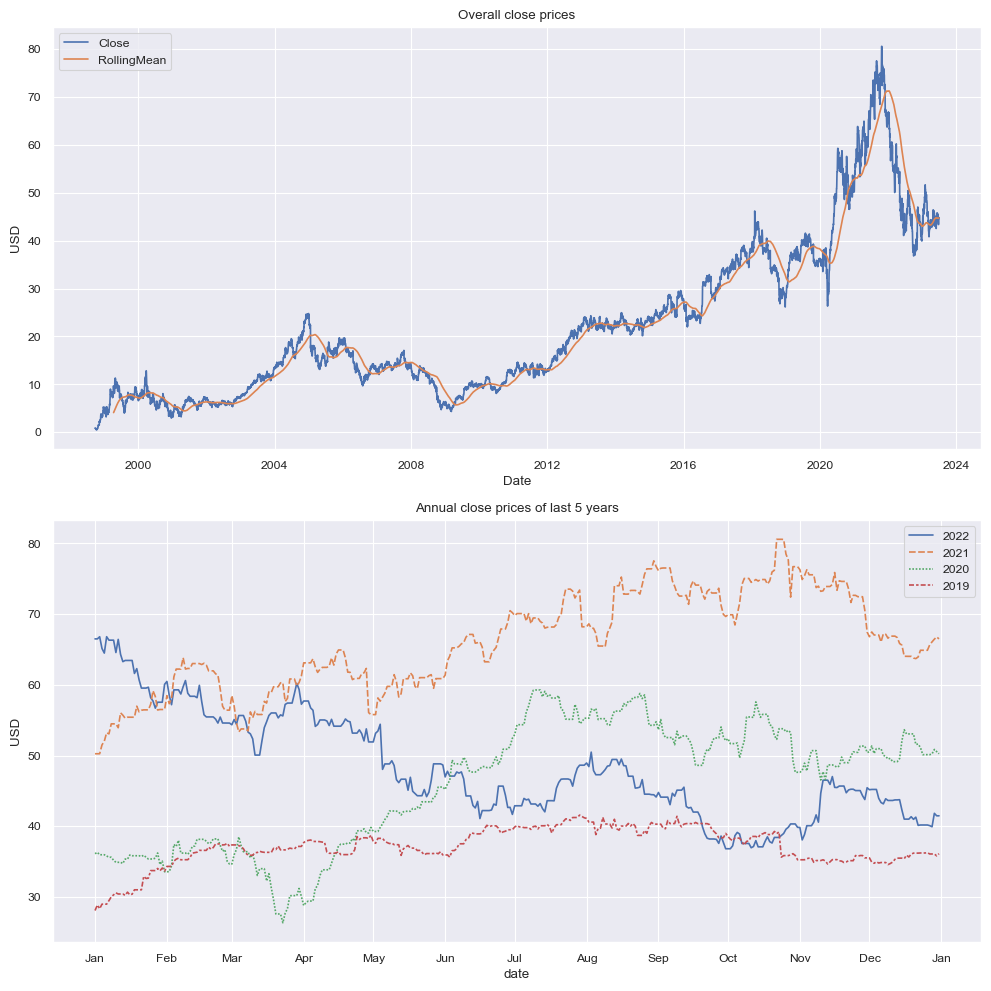

In [38]:


#fig.suptitle(f'Analysis of {ticker.info["longName"]}\n\n', fontsize=25)

#axs[0].set_title('Overall closing price', fontsize=17)
#axs[0].plot(df['Close'], df['Close'].rolling(rolling_resolution).mean()) # .plot(legend=True, label=str(rolling_resolution) + '-day moving average', grid=True)
#axs[0].set_ylabel(ticker.info['currency'])

#plt.subplot(512)
#plt.title('Overall trend', fontsize=17)
#plt.ylabel(ticker.info['currency'])
#decompose.trend.plot(grid=True)

#plt.subplot(513)
#plt.title(f'Annual min/max/mean closing prices last {max_num_of_years} years', fontsize=17)
#plt.fill_between(annualDf.index, annualDf['min'], annualDf['max'], alpha=0.4)
#plt.ylabel(ticker.info['currency'])
#annualDf['mean'].plot(grid=True)

#plt.subplot(514)
#plt.title(f'Annual seasonality last {max_num_of_years} years', fontsize=17)
#plt.axvline(mdates.date2num(dt.datetime(lastYear, dt.date.today().month, dt.date.today().day)), linestyle='dashed')
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
#if seasonalityInPercent:
#    plt.ylabel('%')
#else:
#    plt.ylabel(ticker.info['currency'])
#alpha_value = 1
#for col in annualDf.columns:
#    if col.startswith(periodNames[3]):
#        if seasonalityInPercent:
#            usedAnnualDf = 100 * (annualDf[col] - annualDf[col].iloc[0]) / (annualDf[col].max() - annualDf[col].iloc[0])
#        else:
#            usedAnnualDf = annualDf[col]
#        usedAnnualDf.plot(color='tab:purple', alpha=alpha_value, grid=True)
#        alpha_value = alpha_value * (1 - (2 / numOfYears))

#plt.subplot(515)
#plt.title('Annual monthly mean performance', fontsize=17)
#plt.ylabel(ticker.info['currency'])
#monthlyDf['mean'].plot(kind='bar', yerr=monthlyDf['std'], capsize=4, color=monthlyDf['meanPositive'].map({True: 'tab:green', False: 'tab:red'}), grid=True, rot=0)

#plt.show()

df['RollingMean'] = df['Close'].rolling(rolling_resolution).mean()

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
sns.set_theme('paper')

sns.lineplot(data=df, dashes=False, ax=axs[0], legend='full')
axs[0].set_title('Overall close prices')
axs[0].set_ylabel(ticker.info['currency'])

sns.lineplot(data=annualDf[['2022', '2021', '2020', '2019']], ax=axs[1])
axs[1].set_title(f'Annual close prices of last {max_num_of_years} years')
axs[1].set_ylabel(ticker.info['currency'])
axs[1].xaxis.set_major_locator(mdates.MonthLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%b"))


fig.tight_layout()

